Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt


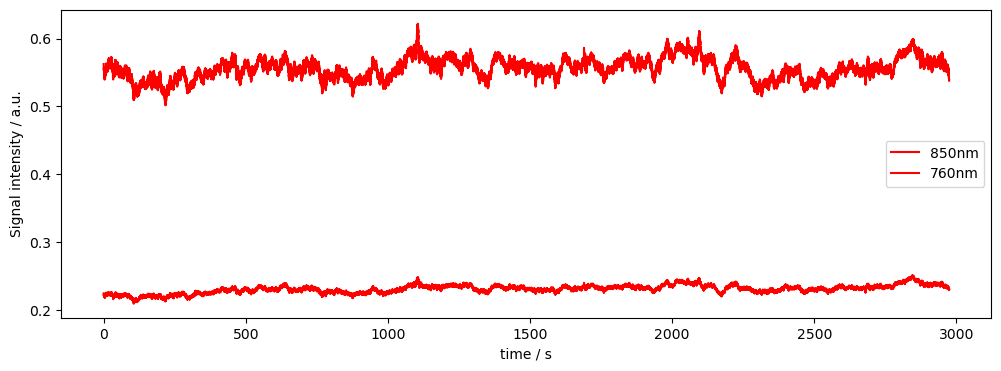

In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.sigproc.motion_correct as motion_correct
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
import cedalion.plots as plots
from cedalion import units
import numpy as np

import cedalion.sim.synthetic_artifact as sa

rec = datasets.get_fingertapping()
rec["od"] = cedalion.nirs.int2od(rec["amp"])

f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S3D3", wavelength="850"), "r-", label="850nm")
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

display(rec["amp"])





## Artifact Generation

Artifacts are generated by functions taking as arguments: 
- time axis of timeseries 
- onset time 
- duration

To enable proper scaling, the amplitude of the generic artifact generated by these functions should be 1.

<xarray.DataArray 'time' (time: 23239)> Size: 186kB
array([0., 0., 0., ..., 1., 1., 1.])
Coordinates:
  * time     (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03

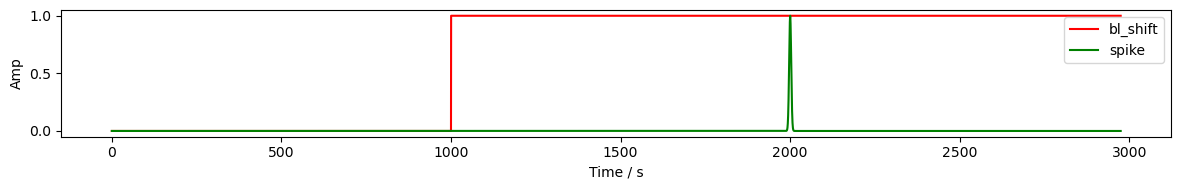

In [2]:
time = rec["amp"].time
sample_bl_shift = sa.gen_bl_shift(time, 1000)
sample_spike = sa.gen_spike(time, 2000, 3)

display(sample_bl_shift)

fig, ax =  p.subplots(1, 1, figsize=(12,2))
ax.plot(time, sample_bl_shift, "r-", label="bl_shift")
ax.plot(time, sample_spike, "g-", label="spike")
ax.set_xlabel('Time / s')
ax.set_ylabel('Amp')
ax.legend()


p.tight_layout()
p.show()

## Controlling Artifact Timing

Artifacts can be placed using a timing dataframe with columns onset_time, duration, trial_type, value, and channel.

We can use the function add_event_timing to create and modify timing dataframes. The function allows precise control over each event.

We can also use the functions random_events_num and random_events_perc to add random events to the dataframe—specifying either the number of events or the percentage of the timeseries duration, respectively.

In [4]:
# Create a list of events in the format (onset, duration)
events = [(1000, 1), (2000, 1)]

# Creates a new timing dataframe with the specified events.
# Setting channel to None indicates that the artifact applies to all channels.
timing_amp = sa.add_event_timing(events, 'bl_shift', None)

# Add random events to the timing dataframe
timing_od = sa.random_events_perc(time, 0.001, ["spike"])

display(timing_amp)
display(timing_od)

,onset,duration,trial_type,value,channel
0,1000,1,bl_shift,1,None
1,2000,1,bl_shift,1,None


,onset,duration,trial_type,value,channel
0,1158.417914,0.307442,spike,1,None
1,1328.829398,0.180179,spike,1,None
2,496.580247,0.219479,spike,1,None
3,2546.673945,0.321066,spike,1,None
4,581.524227,0.182736,spike,1,None
5,514.397136,0.349679,spike,1,None
6,14.828109,0.174856,spike,1,None
7,2793.806060,0.260575,spike,1,None
8,1521.212799,0.342961,spike,1,None
9,2221.382204,0.177023,spike,1,None


## Adding Artifacts to Data

The function add_artifacts automatically scales artifacts and adds them to timeseries data. The function takes arguments
- ts: cdt.NDTimeSeries
- timing: pd.DataFrame
- artifacts: Dict

The artifact functions (see above) are passed as a dictionary. Keys correspond to entries in the column trial_type of the timing dataframe, i.e. each event specified in the timing dataframe is generated using the function artifacts[trial_type].


Window size: 29.0
Adding spike at 1158.4179138929344 for 0.30744214460582875 to ['S1D1' 'S1D2' 'S1D3' 'S1D9' 'S2D1' 'S2D3' 'S2D4' 'S2D10' 'S3D2' 'S3D3'
 'S3D11' 'S4D3' 'S4D4' 'S4D12' 'S5D5' 'S5D6' 'S5D7' 'S5D13' 'S6D5' 'S6D7'
 'S6D8' 'S6D14' 'S7D6' 'S7D7' 'S7D15' 'S8D7' 'S8D8' 'S8D16']
Adding spike at 1328.829398093968 for 0.1801793177761667 to ['S1D1' 'S1D2' 'S1D3' 'S1D9' 'S2D1' 'S2D3' 'S2D4' 'S2D10' 'S3D2' 'S3D3'
 'S3D11' 'S4D3' 'S4D4' 'S4D12' 'S5D5' 'S5D6' 'S5D7' 'S5D13' 'S6D5' 'S6D7'
 'S6D8' 'S6D14' 'S7D6' 'S7D7' 'S7D15' 'S8D7' 'S8D8' 'S8D16']
Adding spike at 496.5802474865417 for 0.2194792933207737 to ['S1D1' 'S1D2' 'S1D3' 'S1D9' 'S2D1' 'S2D3' 'S2D4' 'S2D10' 'S3D2' 'S3D3'
 'S3D11' 'S4D3' 'S4D4' 'S4D12' 'S5D5' 'S5D6' 'S5D7' 'S5D13' 'S6D5' 'S6D7'
 'S6D8' 'S6D14' 'S7D6' 'S7D7' 'S7D15' 'S8D7' 'S8D8' 'S8D16']
Adding spike at 2546.6739454169247 for 0.3210659272496392 to ['S1D1' 'S1D2' 'S1D3' 'S1D9' 'S2D1' 'S2D3' 'S2D4' 'S2D10' 'S3D2' 'S3D3'
 'S3D11' 'S4D3' 'S4D4' 'S4D12' 'S5D5' 'S5D6' '

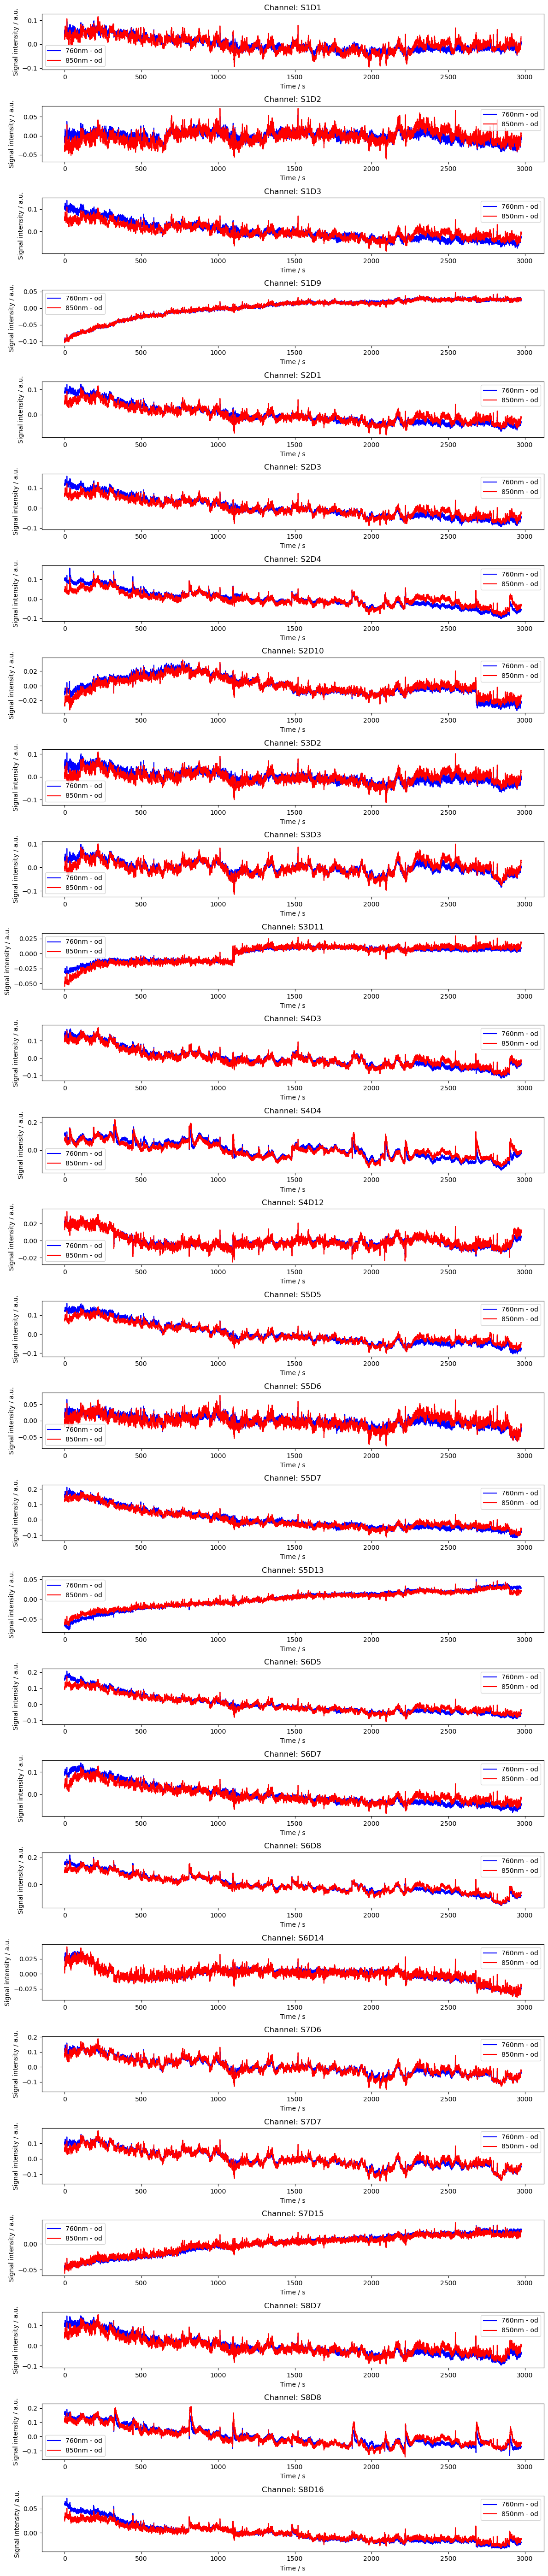

In [5]:
artifacts = {"spike": sa.gen_spike, "bl_shift": sa.gen_bl_shift}

# Add baseline shifts to the amp data
rec["amp"] = sa.add_artifacts(rec["amp"], timing_amp, artifacts)

# Convert the amp data to optical density
rec["od"] = cedalion.nirs.int2od(rec["amp"])

# Add the spikes to OD
rec["od"] = sa.add_artifacts(rec["od"], timing_od, artifacts)

# Plot the data
channels = rec["od"].channel.values
fig, axes = p.subplots(len(channels), 1, figsize=(12, len(channels)*2))
if len(channels) == 1:
    axes = [axes]
for i, channel in enumerate(channels):
    ax = axes[i]
    ax.plot(rec["od"].time, rec["od"].sel(channel=channel, wavelength="760"), 'b-', label='760nm - od')
    ax.plot(rec["od"].time, rec["od"].sel(channel=channel, wavelength="850"), 'r-', label='850nm - od')
    ax.set_title(f'Channel: {channel}')
    ax.set_xlabel('Time / s')
    ax.set_ylabel('Signal intensity / a.u.')
    ax.legend()
p.tight_layout()
p.show()